## Jax入坑指南系列(二):自动微分介绍

### Introduction
在之前的教程里，我们介绍了jax与其基本的框架语法，在这部分将进一步探索jax的高级自动微分功能(Advanced Automatic Differentiation)。
梯度(gradient)或微分(derivatives)的计算是现代科学与工程的底层支柱，同时也是人工智底层实现最重要的方法之一。
在这里，我们结合案例，展示如何利用jax的自动微分功能，解决我们在工程实践中遇到的种种问题。

In [1]:
# Jax's syntax is (for the most part) same as Numpy's
import jax
import jax.numpy as jnp
import numpy as np

#Special transform functions
from jax import grad, jit, vmap, pmap,value_and_grad

#Jax's low-level API 
#lax is just an anagram for XLA, not completely sure how they come up with name JAX
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

###Testing the backend
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


### Recap: 自动微分功能
我们先回顾之前自动微分功能的介绍。
在深度学习中,我们模型的底层大规模地依赖自动微分(automatic differentiation)实现神经网络模型的训练, 在jax中主要通过**grad**函数实现。
假设我们有如下二次函数(quadratic function):
$$
y=f(x_1, x_2, x_3) = x_1^2+x_2^2+z_3^2
$$
在数学上, 对其求偏导(partial derivatives)可得:
$$
\dot{y} = [\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2},\frac{\partial y}{\partial x_3}] = [2x_1, 2x_2, 2x_3]
$$
若我们取初始点，
$$
x_1=0, x_2=1, x_3=2
$$
我们有:
$$
\dot{y} = [\frac{\partial y}{\partial x_1}, \frac{\partial y}{\partial x_2},\frac{\partial y}{\partial x_3}] = [2x_1, 2x_2, 2x_3]=[0,2,4]
$$
我们用jax对其实现求导:

In [2]:
def sum_square(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
loss = sum_square # rename it to give it some semantic

grad_loss = grad(loss)
print(grad_loss(x))

[0. 2. 4.]


当然在神经网络场景里，很多时候我们希望同时计算函数的值和其梯度，这时候可以使用**value_and_grad**函数进行计算，如对于上述，

In [3]:
x = jnp.arange(3.)
loss = sum_square# rename it to give it some semantic

value, grad = value_and_grad(loss)(x)
print("value", value)
print("gradient",grad)

value 5.0
gradient [0. 2. 4.]


我们进一步探索高级自动微分(**grad**与**value_and_grad**)更多的应用。

### 高阶导求解(Higher-order derivatives)
基于Jax强大的自动微分功能, 我们可以很自然地求解给定函数的高阶导(higher-order derivatives), 因为在Jax中其计算导数的函数自身就是可微的(differentiable)。
在jax中,计算函数的高阶导数,就如一层层叠积木一样(as easy as stacking transformations)。
我们先从一个简单的单变量函数例子开始(single-variable case),
函数$f(x)=x^3+2x^2-3x+1$的导数可以表示为:

In [4]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

基于我们大学学过的微积分知识，其四阶内的导数的表达式:
$$
\begin{equation*}
\begin{array}{ll}
    f'(x) &=3x^2+4x-3 \\
    f''(x) &=6x+4 \\
    f'''(x) &=6 \\
    f''''(x) &= 0
\end{array}
\end{equation*}
$$
在jax我们只需要链式地叠加其jax中的grad函数:

In [5]:
dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

若我们取初始值$x_0=1$，有,
$$
\begin{equation*}
\begin{array}{rl}
    f'(1) &=4 \\
    f''(1) &=10 \\
    f'''(1) &=6 \\
    f''''(1) &= 0
\end{array}
\end{equation*}
$$
用jax打印验证一下:

In [6]:
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


#### 雅可比矩阵
当然，在神经网络模型中，我们的参数集合是包含多个变量的参数向量。对于多变量情况下，其高阶导的计算会相对复杂些(偏微分方程与方程组)。在机器学习中，我们经常需要使用如模型损失函数的二阶导; 多变量的二阶导可以表示为一个Hessian矩阵,其矩阵的每个元素$h_{i,j}$为函数对变量$i,j$的偏导:
$$
H_{i,j} =  \frac{\partial^2 f}{\partial_i \partial_j}
$$

**雅可比矩阵:Jacobian Matrix**: 在向量微分中，雅可比矩阵(Jacobian matrix)可以理解为函数的一阶偏导数以一定方式排列成的矩阵。若
$f:\mathbb{R}^n \rightarrow R^m$是从在n维空间$\mathbb{R}^n$映射至m维空间$\mathbb{R}^m$的函数,
$$
\mathbf{f}(x_1,x_2,...,x_n) = (f_1, f_2, ...,f_m)
$$
输入是n维输出是m维,且基于任一自变量的偏导(partial derivatives)都存在。
则该函数的Jacobian矩阵可表示为$m \times n$的矩阵:
$$
J =   [\frac{\partial \mathbf{x}}{\partial x_1}, \frac{\partial \mathbf{x}}{\partial x_2},...,\frac{\partial \mathbf{x}}{\partial x_n} ] =
\begin{bmatrix}
\frac{ \partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \dots & \frac{\partial f_1}{\partial x_n} \\[1ex]
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \dots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\[1ex]
\frac{\partial f_m}{\partial x_1} & \frac{\partial f_m}{\partial x_2} & \dots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}
$$
其中列代表自变量，行代表因变量。

给定上述Jacobian的定义，对于多变量函数f,其Hessian矩阵，可以用其梯度的Jacobian矩阵表示。
Jax提供了两种计算Jacobian矩阵的方法: jac.jacfwd与jax.jacrec,
分别对应于神经网络中的正向(forwar-)与反向(reverse-)model的自动微分计算,
这两个函数的输出是一样，但在不同的场景正确选择使用可以提升我们的计算效率(computational efficency).

我们这里尝试用jacfwd的方式计算其hessian矩阵:

In [7]:
def hessian(f):
  return jax.jacfwd(jax.grad(f))

我们考虑用如下函数来验证上述Hessian计算的准确度，令$f(x)=x^Tx$;对于该函数，其二阶导有:
1. 当$i=j$(对角线)，我们有 $\frac{\partial^2 x}{\partial_i \partial_j}=2$.
2. 当$i \neq j$(非对角线)，我们有$\frac{\partial^2 x}{\partial_i \partial_j}=0$.

In [8]:
def f(x):
  return jnp.dot(x, x)

hessian(f)(jnp.array([1., 2., 3.]))

Array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]], dtype=float32)

和我们手工计算的结果是一致的。

### 边界情况
**边界情况**: 我们现在测试如在计算梯度时出现边界情况的case
$$
\begin{equation*}   f(x) =|x| =  \left\{ \begin{array}{ l l }         x, &\text{if $x>0$} \\         -x,& \text{if $x \leq 0 $}   \end{array} \right. \end{equation*}\\
$$

In [9]:
# Simple helper visualization function
def visual_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

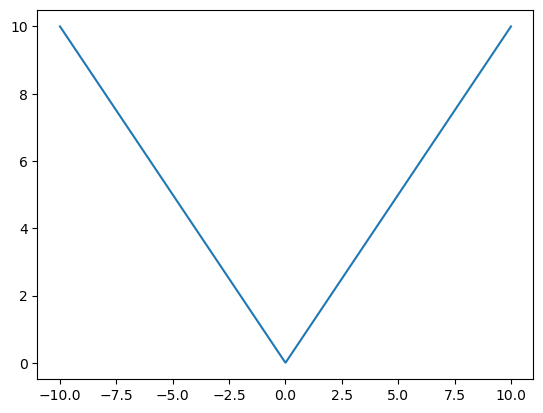

In [10]:
# Edge case |x|, how does JAX handle it?
f = lambda x: abs(x)
visual_fn(f)

对于该函数，我们知道:
  1. 在$x(0,\infty)$之间导数为1.
  2. 在$(-\infty,0)$之间导数为-1.
  3. 在点0处不可导。

In [11]:
print(f(-1), f(1))
dfdx = jax.grad(f)
print(dfdx(0.001), dfdx(-0.001))  # play with numbers around 0 and see how JAX handles it

1 1
1.0 -1.0


### 梯度下降案例
在开始神经网络的介绍前，我们来展开一个简单通过**grad**实现梯度下降(gradient descent)的方法，我们定义如下toy二次函数:
$$
f(x,y,z,w)=x^2+y^2+z^2+w^2\\
$$
我们希望通过grad求解其最小值参数(0,0,0,0)，
$$\underset{x,y,z,w}{f(x,y,z,w)}$$

用python lambda函数表示:

In [12]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2 

对于该函数，若用随机梯度下降(stochastic gradient descent)算法对其进行求解:
   1. 初始化其参数权重，我们这里先初始化为(1,1,1,1)).
   2. 通过jax里的grad函数对当前状态与参数进行梯度计算，然后基于梯度下降法对参数进行迭代更新: $\theta = \theta - lr * \nabla \theta$

In [13]:
#初始化模型参数 parameter weight
x, y, z, w = [1.]*4 
lr = 0.1
num_epochs = 30
for _ in range(num_epochs):
    #通过grad函数模块计算梯度(偏导)
    #默认只返回第一个，所以这里argnums我们显式地定义4个
    dfdx, dfdy, dfdz, dfdw = jax.grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
    # 通过梯度下降方法更新我们的参数
    x -= lr*dfdx
    y -= lr*dfdy
    z -= lr*dfdz
    w -= lr*dfdw     

    print("x",x, "y",y, "z",z,"w",w)

x 0.8 y 0.8 z 0.8 w 0.8
x 0.64 y 0.64 z 0.64 w 0.64
x 0.51199996 y 0.51199996 z 0.51199996 w 0.51199996
x 0.40959996 y 0.40959996 z 0.40959996 w 0.40959996
x 0.32767996 y 0.32767996 z 0.32767996 w 0.32767996
x 0.26214397 y 0.26214397 z 0.26214397 w 0.26214397
x 0.20971517 y 0.20971517 z 0.20971517 w 0.20971517
x 0.16777214 y 0.16777214 z 0.16777214 w 0.16777214
x 0.13421771 y 0.13421771 z 0.13421771 w 0.13421771
x 0.10737417 y 0.10737417 z 0.10737417 w 0.10737417
x 0.08589934 y 0.08589934 z 0.08589934 w 0.08589934
x 0.06871947 y 0.06871947 z 0.06871947 w 0.06871947
x 0.054975577 y 0.054975577 z 0.054975577 w 0.054975577
x 0.04398046 y 0.04398046 z 0.04398046 w 0.04398046
x 0.03518437 y 0.03518437 z 0.03518437 w 0.03518437
x 0.028147494 y 0.028147494 z 0.028147494 w 0.028147494
x 0.022517996 y 0.022517996 z 0.022517996 w 0.022517996
x 0.018014397 y 0.018014397 z 0.018014397 w 0.018014397
x 0.014411518 y 0.014411518 z 0.014411518 w 0.014411518
x 0.011529215 y 0.011529215 z 0.011529215 w 

### 总结
在今天的文章里，我们走马观花地尝试jax的自动微分功能及其主要的应用。可以感受到其自动微分能力可以使得我们基于jax搭建强大的如强化学习模型，控制模型框架。我们后续将介绍完jax与flax的神经网络框架后进一步探索如何利用jax的自动微分功能实现更复杂且强大的模型系统。